# What do consumers value in a used car?

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 



### Background
Used car dealerships purchase pre-owned vehicles at a price based on the vehicle's features and re-sell the vehicle for a profit.  

### Business Objectives
Understand what factors make a car more or less expensive.

### Business Success Criteria
Identification of factors that influence the price of a car.

### Data Problem Definition
Predict the price of a vehicle based on the factors provided in the dataset. Determine what factors influence this price the most (either increasing its value, or decreasing its value)

### Assumptions
Assuming the provided dataset is ligitimate data obtained via a trusted source.

### Constraints

### Risks and Contingencies

### Terminology

### Costs and Benefits

### Data Mining Goals

### Data Mining Success Criteria 

### Project Plan

### Assessment of Tools and Techniques


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [11]:
# Shape of dataset
df.shape

(426880, 18)

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


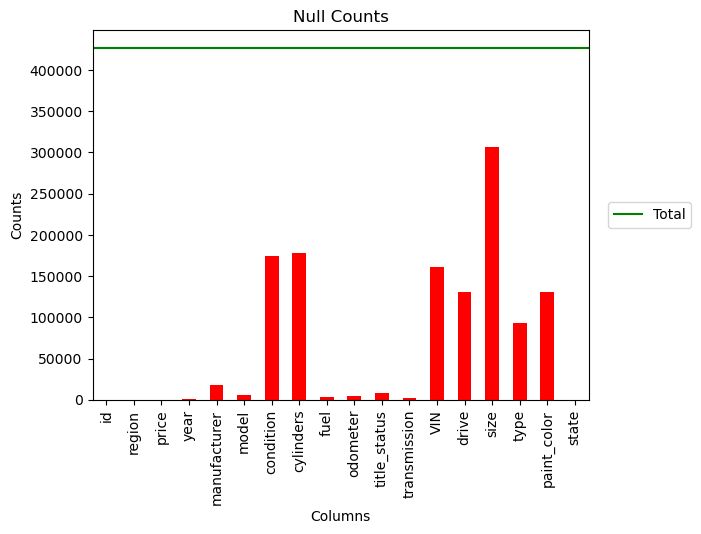

In [23]:
df.isnull().sum().plot(kind='bar', color='r')
plt.axhline(y=df.shape[0], color='g', linestyle='-', label='Total')
plt.title('Null Counts')
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

print(df.isnull().sum() / df.shape[0] * 100)

The data contains null values. Some columns more than others. Size is missing 71% of its values. Our target variable, price, is present for all rows. WIll be droping column missing a majority of its data as it will not be usefull for modeling.

In [49]:
# Examine numeric data
df.select_dtypes(include='number').describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Price ranges from $0 to $3,736,928,711. That seems a bit ridiculous. Will be triming the dataset of outliers.

Year ranges from 1900 to 2022. It is currently a float.

In [51]:
# Examine catagorical data
for column in df.select_dtypes(exclude='number').columns:
    print(f'-----------{column}-----------')
    print(df[[column]].value_counts(normalize=True, dropna=False))
    print('-------------------------------')

-----------region-----------
region                 
columbus                   0.008452
jacksonville               0.008344
spokane / coeur d'alene    0.007000
eugene                     0.006993
fresno / madera            0.006988
                             ...   
meridian                   0.000066
southwest MS               0.000033
kansas city                0.000026
fort smith, AR             0.000021
west virginia (old)        0.000019
Length: 404, dtype: float64
-------------------------------
-----------manufacturer-----------
manufacturer   
ford               0.166288
chevrolet          0.128992
toyota             0.080121
honda              0.049824
nissan             0.044666
jeep               0.044542
ram                0.042968
NaN                0.041337
gmc                0.039320
bmw                0.034434
dodge              0.032110
mercedes-benz      0.027682
hyundai            0.024218
subaru             0.022243
volkswagen         0.021891
kia                0

### Data Understanding

Since the dataset does not come with any definitions, I will infer and assume their meaning and units of measure. 
The data contains state codes from the USA, therfore I will assume this data is using imperial units (Miles) and values is in US Dollars

| Column       | Definition        | Understanding          
|--------------|-------------------|------------------------|
| Region  | Region where the car was purchased/sold   | Values are strings that are not standardized. Values are city names, general areas of the US, some cities contain the state codes, etc. This column will require some cleaning, if not dropping entirely. State will likely be enough for geographical reference     |
| price  | $ (Assuming US Dollars) Value the car was sold for   | This will be our target variable and indicator of value. Price exists for 100% of the rows. Price ranges from $0 to $3,736,928,711. This will require some outlier removal     |
| year  | Year the car was manufactured   | Car manufacture year ranging from 1900 to 2022.     |
| manufacturer  | Manufacturer (Make) of the car   | Values are strings such as ford, gmc, volvo, etc. This should be useful. This data can also be interpreted via the VIN     |
| model  | Model of the car (differs between makes)   | Values are strings such as f-150, camery, 1500, etc. that are not standardized. Values are unique per manufacturer. Similar data can be interpreted from the VIN and will be more standardized.     |
| condition  | Subjective definition of the cars status at the time of selling/purchase   | This data is highly subjective, likely will not be of importance for modeling     |
| cylinders  | Size of engine (Electric cars will not have an engine)   | Engine size is a strong indicator of value, larger engine will likely cost more. Note: Electric vehicles have no engine     |
| fuel  | Type of fuel used in the car   | Fuel type will likely be an important factor for vehicle value. Fuel type impacts the performance and cost of operation.     |
| odometer  | Number of miles (assuming miles) the car has already been driven   | Odometer reading can be used to determine the life left in a vehicle. The higher the odometer, the less life left in the engine. Esitmated vehicle life expectancy differs by manufacture.     |
| title_status  | Status of the legal title for the car   | This can give an idea how the car may have been treated during its ownership     |
| transmission  | Transmissing type of the car (Electric vehicles only have automatic transmission)   | Important indication of vehicle capability     |
| VIN  | Vehicle Identification Number   | Contains encoded data that can be decoded, will likely split this identifier up into its useful pieces. A VIN is unique     |
| drive  | Powertrain of the vehicle   | Important indication of vehicle capability     |
| size  | Size of vehicle, this data is mostly missing and will be removed from analysis    | Understanding of 3     |
| type  | Type of Vehicle   | String value such as truck, SUV, pickup, etc.      |
| paint_color  | Color of vehicle   | Can be a factor for car value. Not many people would like to drive a car with a ungly color.     |
| state  | State the vehicle was purchased/sold in   | Understanding of 3     |
| ...          | ...               | ...                    |


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [349]:
df = df[[
    # Commenting out id
    # 'id', 
    'region', 
    'price', 
    'year', 
    'manufacturer', 
    'model', 
    'condition',
    'cylinders', 
    'fuel', 
    'odometer', 
    'title_status', 
    'transmission', 
    'VIN',
    'drive', 
    'size', 
    'type', 
    'paint_color', 
    'state'
    ]].copy()

In [289]:
# Percentage of each column that is missing
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(426880, 17)


region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

In [290]:
# 71% of size is missing, this data can be determined from the VIN, dropping this column
df = df.drop('size', axis=1)

In [291]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(426880, 16)


region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

In [292]:
df['condition'].value_counts(dropna=False, normalize=True)

NaN          0.407852
good         0.284520
excellent    0.237694
like new     0.049611
fair         0.015857
new          0.003057
salvage      0.001408
Name: condition, dtype: float64

In [293]:
# Condition is too subjective, dropping this column
df = df.drop('condition', axis=1)

In [294]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(426880, 15)


region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64

In [295]:
df['cylinders'].value_counts(dropna=False, normalize=True)

NaN             0.416225
6 cylinders     0.220598
4 cylinders     0.181882
8 cylinders     0.168811
5 cylinders     0.004010
10 cylinders    0.003408
other           0.003041
3 cylinders     0.001534
12 cylinders    0.000490
Name: cylinders, dtype: float64

In [296]:
# Cylinders is an important factor in a vehicle, I will remove null values.
df = df.dropna(subset=['cylinders'])

# Will drop rows with "other"
df = df[df['cylinders'] != 'other']
 
# Will convert this to numeric value as well
mapping = {
    "3 cylinders": 3,
    "4 cylinders": 4,
    "6 cylinders": 6,
    "5 cylinders": 5,
    "8 cylinders": 8,
    "10 cylinders": 10,
    "12 cylinders": 12
    }

df['cylinders'] = df['cylinders'].map(mapping)

df['cylinders'].value_counts(dropna=False, normalize=True)

6     0.379861
4     0.313194
8     0.290685
5     0.006906
10    0.005869
3     0.002642
12    0.000843
Name: cylinders, dtype: float64

In [297]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(247904, 15)


region           0.000000
price            0.000000
year             0.450981
manufacturer     3.747418
model            0.986269
cylinders        0.000000
fuel             0.565138
odometer         0.604266
title_status     2.553408
transmission     0.074626
VIN             41.419662
drive           14.126839
type            11.067591
paint_color     19.843165
state            0.000000
dtype: float64

In [298]:
df['year'].value_counts(dropna=False, normalize=True)

2017.0    0.077921
2013.0    0.072754
2015.0    0.071108
2014.0    0.071100
2018.0    0.069144
            ...   
1915.0    0.000004
1900.0    0.000004
1905.0    0.000004
1918.0    0.000004
1920.0    0.000004
Name: year, Length: 108, dtype: float64

In [299]:
# Drop null values of year
df = df.dropna(subset=['year'])

# Change from float to int
df['year'] = df['year'].astype(int)

# Max and Min Year
print(df['year'].max(), df['year'].min())

2022 1900


In [300]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(246786, 15)


region           0.000000
price            0.000000
year             0.000000
manufacturer     3.313802
model            0.990737
cylinders        0.000000
fuel             0.488683
odometer         0.606598
title_status     2.467320
transmission     0.074964
VIN             41.607303
drive           14.102907
type            11.072751
paint_color     19.902669
state            0.000000
dtype: float64

In [301]:
df['manufacturer'].value_counts(dropna=False, normalize=True)

ford               0.168855
chevrolet          0.138796
toyota             0.085929
honda              0.052548
jeep               0.048042
nissan             0.045841
ram                0.044897
gmc                0.043823
dodge              0.033681
NaN                0.033138
bmw                0.029447
mercedes-benz      0.027680
hyundai            0.022347
subaru             0.021638
lexus              0.020500
volkswagen         0.020078
kia                0.017051
chrysler           0.015722
audi               0.015576
cadillac           0.014620
acura              0.013068
buick              0.012294
infiniti           0.011994
mazda              0.010864
lincoln            0.009129
mitsubishi         0.006281
pontiac            0.006155
volvo              0.005867
mini               0.004931
rover              0.004380
mercury            0.003485
porsche            0.003311
jaguar             0.002755
saturn             0.002642
fiat               0.001337
alfa-romeo         0

In [302]:
# Drop all null values of manufacturer
df = df.dropna(subset=['manufacturer'])

In [303]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(238608, 15)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            1.024693
cylinders        0.000000
fuel             0.475676
odometer         0.621521
title_status     2.518776
transmission     0.077114
VIN             40.956297
drive           14.085446
type            10.823610
paint_color     20.060937
state            0.000000
dtype: float64

In [304]:
df['model'].value_counts(dropna=False, normalize=True)

f-150                    0.017942
silverado 1500           0.014488
NaN                      0.010247
1500                     0.009887
camry                    0.007967
                           ...   
4500 kodiack             0.000004
f-350sd xl               0.000004
camry trd v6             0.000004
200 limited 4dr sedan    0.000004
gand wagoneer            0.000004
Name: model, Length: 18030, dtype: float64

In [305]:
# Model is not standardized and inconsistant between manufacturers, dropping this column. This data can be infered from the VIN
df = df.drop('model', axis=1)

In [306]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(238608, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.475676
odometer         0.621521
title_status     2.518776
transmission     0.077114
VIN             40.956297
drive           14.085446
type            10.823610
paint_color     20.060937
state            0.000000
dtype: float64

In [307]:
# VIN is important, contains a lot of important imformation about the vehicle

# Drop all rows missing a VIN
df = df.dropna(subset=['VIN'])

In [308]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(140883, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.790727
odometer         0.481960
title_status     4.234010
transmission     0.130605
VIN              0.000000
drive           16.104853
type             5.459850
paint_color     23.422272
state            0.000000
dtype: float64

In [309]:
# Odometer is an important metric for measuring use of vehicle and life left

# Drop all rows missing odometer reading
df = df.dropna(subset=['odometer'])

In [310]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(140204, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.791704
odometer         0.000000
title_status     4.254515
transmission     0.131237
VIN              0.000000
drive           16.181421
type             5.404268
paint_color     23.300334
state            0.000000
dtype: float64

In [312]:
df['fuel'].value_counts(dropna=False, normalize=True)

gas         0.867065
diesel      0.068964
other       0.043365
hybrid      0.012025
NaN         0.007917
electric    0.000663
Name: fuel, dtype: float64

In [313]:
# Fuel type for a vehicle is important

# Drop all missing fuel types
df.dropna(subset=['fuel'], inplace=True)

# Catagorize them into electric, hybrid, gas, diesel (assuming other is gas)
mapping = {
    "other": "gas"
}
df['fuel'] = df['fuel'].map(mapping).fillna(df['fuel'])

df['fuel'].value_counts(dropna=False, normalize=True)

gas         0.917696
diesel      0.069514
hybrid      0.012121
electric    0.000669
Name: fuel, dtype: float64

In [315]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(139094, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     4.237422
transmission     0.130128
VIN              0.000000
drive           16.169641
type             5.392037
paint_color     23.400003
state            0.000000
dtype: float64

In [316]:
df['title_status'].value_counts(dropna=False, normalize=True)

clean         0.939674
NaN           0.042374
rebuilt       0.011165
salvage       0.005104
lien          0.001352
missing       0.000288
parts only    0.000043
Name: title_status, dtype: float64

In [317]:
# Could be interesting data. While a majority is clean, I will just remove null values
df.dropna(subset=['title_status'], inplace=True)

In [318]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(133200, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.135886
VIN              0.000000
drive           14.397147
type             5.622372
paint_color     20.328078
state            0.000000
dtype: float64

In [319]:
df['transmission'].value_counts(dropna=False, normalize=True)

automatic    0.768694
other        0.187763
manual       0.042185
NaN          0.001359
Name: transmission, dtype: float64

In [320]:
# Will remove null values
df.dropna(subset=['transmission'], inplace=True)

In [321]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(133019, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
VIN              0.000000
drive           14.295702
type             5.630023
paint_color     20.348973
state            0.000000
dtype: float64

In [323]:
df['drive'].value_counts(dropna=False, normalize=True)

4wd    0.420707
fwd    0.269525
rwd    0.166811
NaN    0.142957
Name: drive, dtype: float64

In [324]:
# Will remove null values
df.dropna(subset=['drive'], inplace=True)

In [325]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(114003, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
VIN              0.000000
drive            0.000000
type             5.655992
paint_color     19.032832
state            0.000000
dtype: float64

In [326]:
df['type'].value_counts(dropna=False, normalize=True)

sedan          0.234231
SUV            0.233283
truck          0.145593
pickup         0.118339
NaN            0.056560
coupe          0.055481
other          0.042429
van            0.032894
wagon          0.027078
hatchback      0.023482
convertible    0.017280
mini-van       0.011886
offroad        0.000947
bus            0.000518
Name: type, dtype: float64

In [327]:
# Remove null values
df.dropna(subset=['type'], inplace=True)

In [328]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(107555, 14)


region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
VIN              0.000000
drive            0.000000
type             0.000000
paint_color     17.716517
state            0.000000
dtype: float64

In [329]:
df['paint_color'].value_counts(dropna=False, normalize=True)

white     0.218186
NaN       0.177165
black     0.169560
silver    0.117400
grey      0.083381
red       0.081605
blue      0.081605
custom    0.024006
green     0.018279
brown     0.017424
yellow    0.005374
orange    0.004295
purple    0.001720
Name: paint_color, dtype: float64

In [330]:
# Remove null values
df.dropna(subset=['paint_color'], inplace=True)

In [331]:
print(df.shape)
df.isnull().sum() / df.shape[0] * 100

(88500, 14)


region          0.0
price           0.0
year            0.0
manufacturer    0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
VIN             0.0
drive           0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

In [332]:
# Checking for duplicatd VINs
df.loc[df.duplicated(subset=['VIN'])]

,region,price,year,manufacturer,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
230,birmingham,27990,2012,gmc,8,gas,68696.0,clean,other,1GT220CG8CZ231238,4wd,pickup,black,al
251,birmingham,29990,2016,chevrolet,6,gas,17302.0,clean,other,1GCHTCE37G1186784,4wd,pickup,red,al
285,birmingham,32990,2017,jeep,6,gas,30041.0,clean,other,1C4BJWDG5HL705371,4wd,other,silver,al
422,birmingham,3399,2006,buick,6,gas,160218.0,clean,automatic,2G4WD582061211256,fwd,sedan,blue,al
425,birmingham,3900,2009,hyundai,4,gas,162005.0,clean,automatic,KMHDU46D49U684737,rwd,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426859,wyoming,48590,2020,cadillac,6,gas,7701.0,clean,other,1GYKPCRSXLZ181516,fwd,other,black,wy
426860,wyoming,39990,2017,infiniti,8,gas,41664.0,clean,automatic,JN8AZ2NE3H9156734,4wd,other,black,wy
426866,wyoming,32990,2016,infiniti,8,gas,55612.0,clean,automatic,JN8AZ2NF5G9611039,rwd,other,black,wy
426874,wyoming,33590,2018,lexus,6,gas,30814.0,clean,automatic,JTHBZ1BLXJA012999,rwd,sedan,white,wy


In [338]:
df.groupby('VIN').filter(lambda x: x['price'].nunique() > 1)

,region,price,year,manufacturer,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
215,birmingham,4000,2002,toyota,4,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,sedan,blue,al
364,birmingham,7300,2007,lexus,6,gas,181000.0,clean,automatic,2T2GK31U57C025466,fwd,SUV,white,al
418,birmingham,4275,2006,jeep,6,gas,174132.0,clean,automatic,1J8GL48K06W123802,4wd,SUV,red,al
489,birmingham,15990,2015,chevrolet,6,gas,53000.0,clean,automatic,2G1FB1E38F9300602,rwd,other,black,al
738,birmingham,31500,2019,gmc,8,gas,24585.0,clean,automatic,1GTW7AFG9K1222985,rwd,van,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424832,milwaukee,17452,2017,ford,6,gas,154589.0,clean,automatic,1FTYR2ZGXHKA96370,rwd,van,white,wi
424836,milwaukee,6981,2010,chrysler,6,gas,166410.0,clean,automatic,2A4RR5DX2AR137136,fwd,van,black,wi
424838,milwaukee,16487,2008,nissan,8,gas,103165.0,clean,automatic,1N6BA07C48N359238,4wd,truck,custom,wi
426523,wyoming,17000,1996,ford,8,diesel,246000.0,clean,automatic,1FTHX26F2TEB44761,4wd,truck,green,wy


In [339]:
# Example of duplicatd VIN
df.query("VIN == 'JTDBT123520243495'")

,region,price,year,manufacturer,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
215,birmingham,4000,2002,toyota,4,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,sedan,blue,al
121767,atlanta,3995,2002,toyota,4,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,sedan,blue,ga
351600,chattanooga,4000,2002,toyota,4,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,sedan,blue,tn


In [342]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(76142, 14)

In [344]:
df.head()

,region,price,year,manufacturer,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
32,auburn,27990,2012,gmc,8,gas,68696.0,clean,other,1GT220CG8CZ231238,4wd,pickup,black,al
33,auburn,34590,2016,chevrolet,6,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,pickup,silver,al
35,auburn,29990,2016,chevrolet,6,gas,17302.0,clean,other,1GCHTCE37G1186784,4wd,pickup,red,al
36,auburn,38590,2011,chevrolet,8,gas,30237.0,clean,other,1G1YR3DW3B5102190,rwd,other,red,al
38,auburn,32990,2017,jeep,6,gas,30041.0,clean,other,1C4BJWDG5HL705371,4wd,other,silver,al


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
linear

In [ ]:
ridge

In [ ]:
lasso

In [ ]:
something else

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.